In [3]:
import torch
import numpy as np
import os
import os.path as osp
import sys
import time
from tqdm.autonotebook import tqdm
import matplotlib.pylab as plt
from torch import nn
from torch import optim
from torch.utils.tensorboard import SummaryWriter
from collections import defaultdict

sys.path.append('../..')

## Imports based on our ready-to-use code (after you pip-install the cs233_gtda_hw4 package)
from cs233_gtda_hw4.in_out.utils import make_data_loaders
from cs233_gtda_hw4.in_out.utils import save_state_dicts, load_state_dicts
from cs233_gtda_hw4.in_out import pointcloud_dataset
from cs233_gtda_hw4.in_out.plotting import plot_3d_point_cloud


## Imports you might use if you follow are scaffold code (it is OK to use your own stucture of the models)
from cs233_gtda_hw4.models import FancyPartAwarePointcloudAutoencoder
from cs233_gtda_hw4.models.point_net import PointNet
from cs233_gtda_hw4.models.mlp import MLP

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
##
## Fixed Settings (we do not expect you to change these)
## 

n_points = 1024  # number of points of each point-cloud
n_parts = 4      # max number of parts of each shape
n_train_epochs = 1000 #400

# Students: feel free to change below -ONLY- for the bonus Question:
# I.e., use THESE hyper-parameters when you train for the non-bonus questions.

part_lambda = 0.005  # for the part-aware AE you will be using (summing) two losses:
                     # chamfer + cross-entropy
                     # do it like this: chamfer + (part_lambda * cross-entropy), 
                     # i.e. we are scaling down the cross-entropy term
init_lr = 0.015  # .009  # initial learning-rate, tested by us with ADAM optimizer (see below)

In [5]:
## Students: feel free to change below:

# batch-size of data loaders
batch_size = 128 # if you can keep this too as is keep it, 
                 # but if it is too big for your GPU, feel free to change it.

# which device to use: cpu or cuda?

# device = 'cpu'     # Note: only the "alternative" (slower) chamfer_loss in losses/nn_distance can run in cpu.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

top_in_dir = '../data/'
top_out_dir = '../data/out/'
if not osp.exists(top_out_dir):
    os.makedirs(top_out_dir)
    
top_log_dir = '../data/logs/'
if not osp.exists(top_log_dir):
    os.makedirs(top_log_dir)

In [14]:
# PREPARE DATA:

loaders = make_data_loaders(top_in_dir, batch_size)

for split, loader in loaders.items():
    print('N-examples', split, len(loader.dataset))
    
# BUILD MODELS:
### TODO: Student on your own:
out_n = n_points
drop = 0.0
bnorm = False
noise = 0
alpha = 0
cdec = 1
kl_lambda = 0
kdec = 1
encode_parts = False
predict_parts = False
variational = False

encoder = PointNet(conv_dims=[32, 64, 64, 128, 128])
decoder = MLP(128, [256, 384, out_n*3], b_norm=bnorm, dropout_rate=drop)
part_classifier = PointNet(128+3, [64, n_parts], max_pool=False)

N-examples train 750
N-examples test 150
N-examples val 50


In [15]:
part_aware_model = True # or True

model = FancyPartAwarePointcloudAutoencoder(
    encoder, decoder, part_classifier,
    part_lambda, device=device, class_decay=cdec, decode_alpha=alpha,
    variational=variational, kl_lambda=kl_lambda, noise=noise,
    kl_decay=kdec, encode_parts=encode_parts, predict_parts=predict_parts).to(device) # Students Work here

model_tag = (f'experiment' + 
             f'_drop{drop}' + 
             f'{"_bnorm" if bnorm else ""}' + 
             f'_kl{kl_lambda:.0e}' + 
             f'_noisy{noise}' + 
             f'_cdec{cdec}' + 
             f'_alpha{alpha}' +
             f'_kdec{kdec}' + 
             f'_predpts{predict_parts}' + 
             f'_encpts{encode_parts}' +
             f'{"_var" if variational else ""}' + 
             '_')

In [16]:
optimizer = optim.Adam(model.parameters(), lr=init_lr)  # Students uncomment once you have defined your model

In [17]:
min_val_loss = np.Inf
out_file = osp.join(top_out_dir, model_tag + 'best_model.pth')
start_epoch = 1

In [22]:
## Train for multiple epochs your model.
# Students: the below for-loops are optional, feel free to structure your training 
# differently.

writer = SummaryWriter(log_dir=osp.join(top_log_dir, model_tag + time.strftime("%Y%m%d-%H%M%S")))
for epoch in tqdm(range(start_epoch, start_epoch + n_train_epochs)):
    for phase in ['train', 'val', 'test']:
        # Students Work Here.
        if phase == 'train':
            epoch_losses, epoch_recon_losses, epoch_xentr_losses, epoch_kl_losses = model.train_for_one_epoch(loaders[phase], optimizer, device)
                
            if model.variational:
                writer.add_scalar('Loss/kl/train', epoch_kl_losses, epoch)
            if part_aware_model:
                writer.add_scalar('Loss/xentr/train', epoch_xentr_losses, epoch)
                
            writer.add_scalar('Loss/total/train', epoch_losses, epoch)
            writer.add_scalar('Loss/recon/train', epoch_recon_losses, epoch)
        else:
            _, _, val_losses, val_recon_losses, val_xentr_losses, val_kl_losses = model.reconstruct(loaders[phase], device)
                
            if model.variational:
                writer.add_scalar(f'Loss/kl/{phase}', val_kl_losses, epoch)
            if part_aware_model:
                writer.add_scalar(f'Loss/xentr/{phase}', val_xentr_losses, epoch)
            
            writer.add_scalar(f'Loss/total/{phase}', val_losses, epoch)
            writer.add_scalar(f'Loss/recon/{phase}', val_recon_losses, epoch)

        # Save model if validation loss improved.
        if phase == 'val' and val_recon_losses < min_val_loss:
            min_val_loss = val_recon_losses
           
            # If you save the model like this, you can use the code below to load it. 
            save_state_dicts(out_file, epoch=epoch, model=model) 

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

UnboundLocalError: local variable 'label' referenced before assignment

In [8]:
# Load model with best per-validation loss (uncomment when ready)
best_epoch = load_state_dicts(out_file, model=model, map_location=torch.device(device))
print('per-validation optimal epoch', best_epoch)
print('per-validation optimal recon loss', f'{min_val_loss.item():.3e}')

per-validation optimal epoch 836


AttributeError: 'float' object has no attribute 'item'

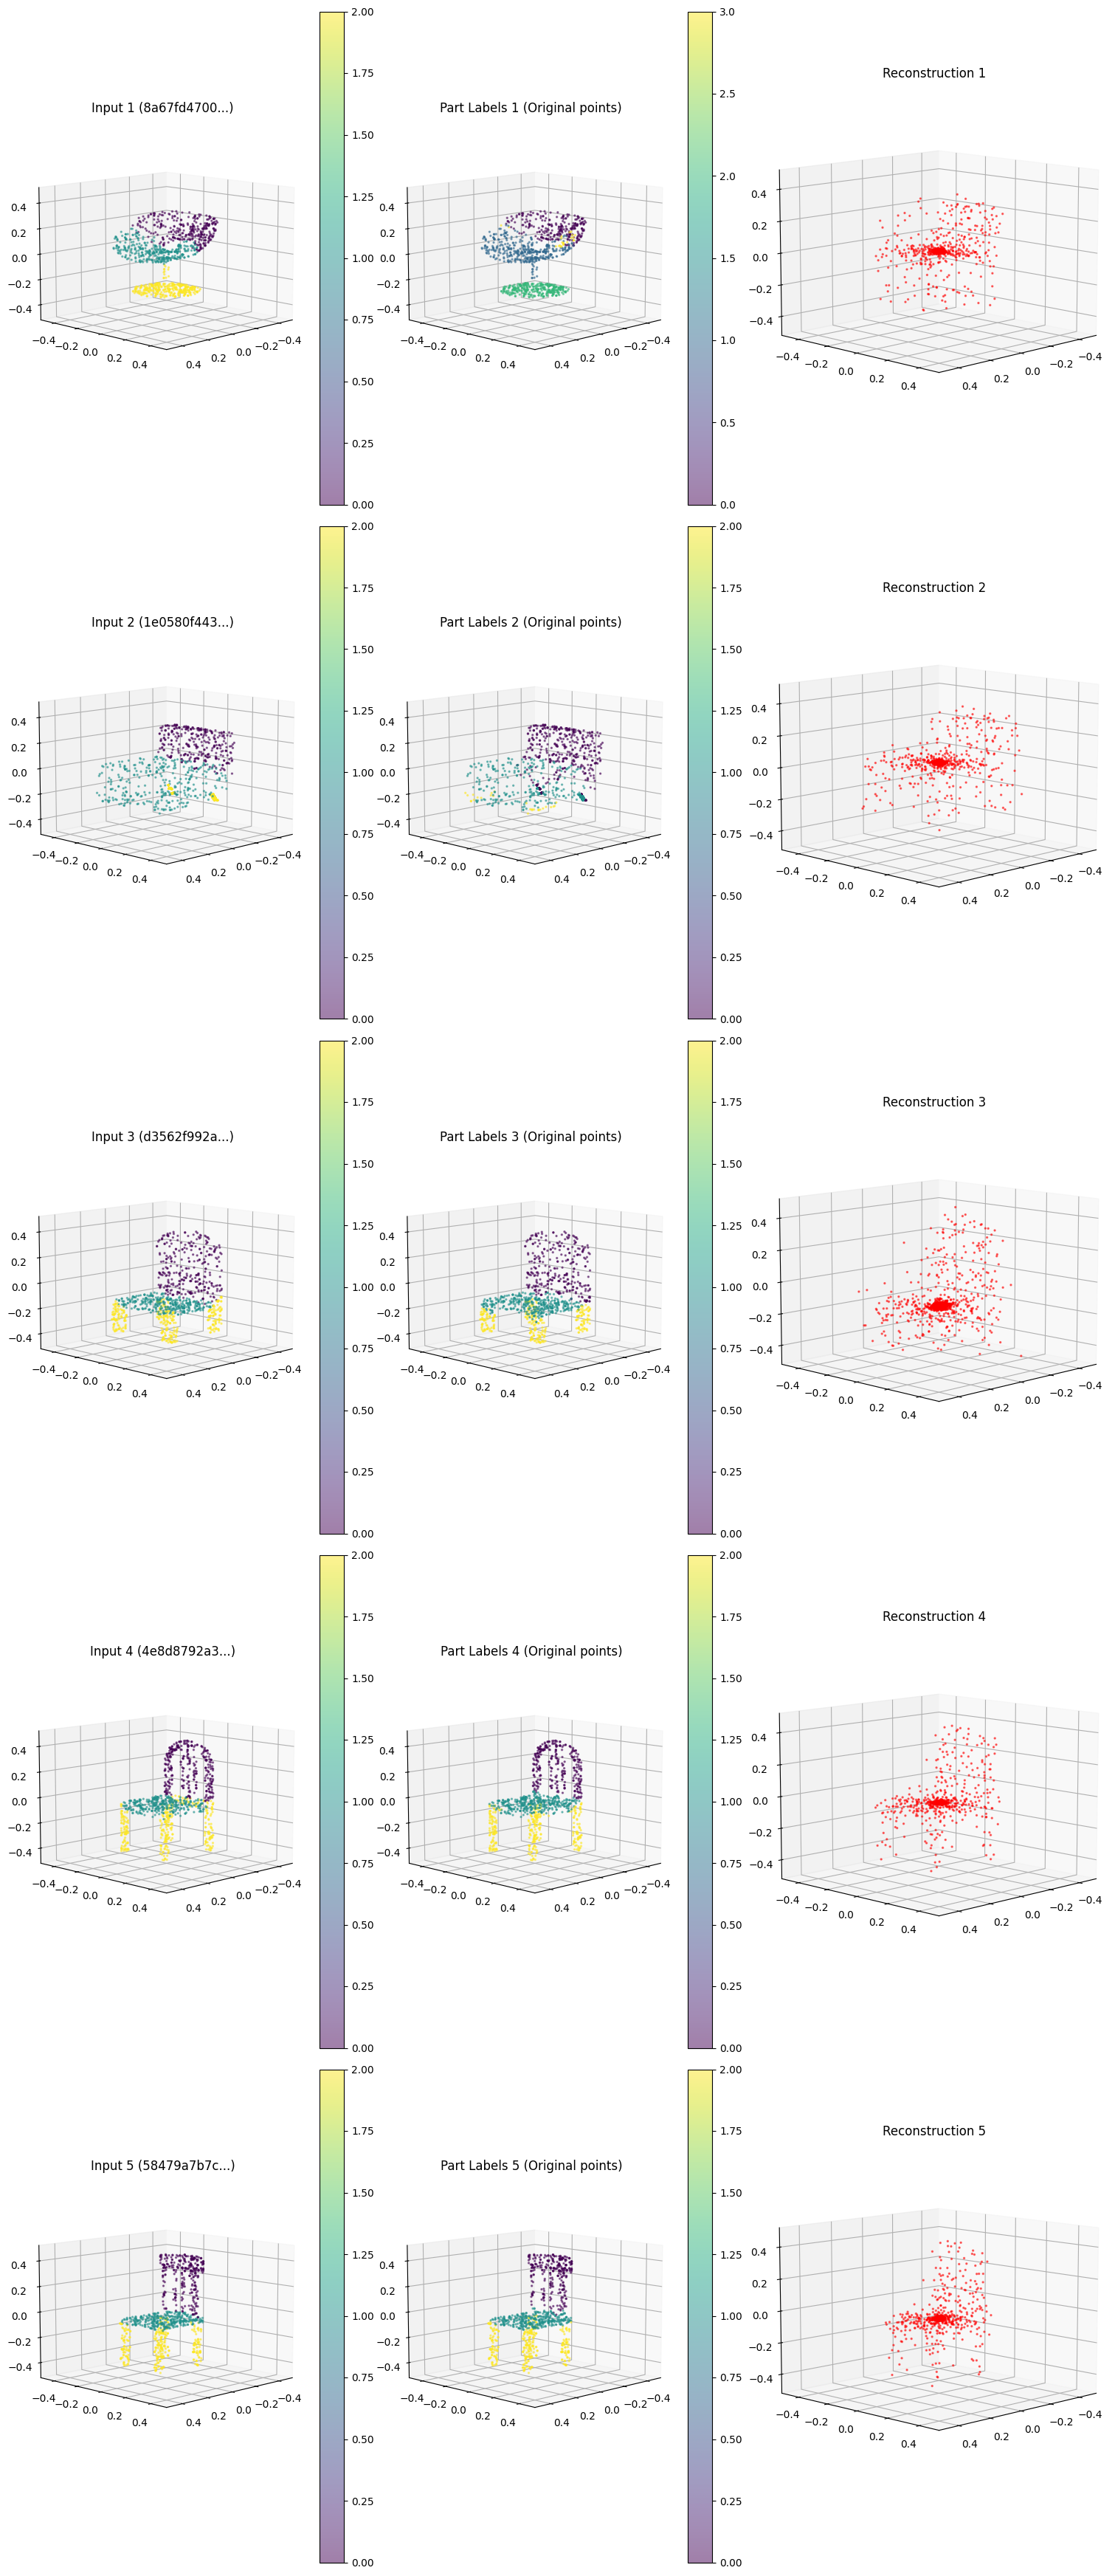

In [9]:
# Students TODO: MAKE your plots and analysis

# 5 examples to visualize per questions (e, f)
examples_to_visualize = ['8a67fd47001e52414c350d7ea5fe2a3a',
                         '1e0580f443a9e6d2593ebeeedbff73b',
                         'd3562f992aa405b214b1fd95dbca05',
                         '4e8d8792a3a6390b36b0f2a1430e993a',
                         '58479a7b7c157865e68f66efebc71317']

# You can (also) use the function for the reconstructions or the part-predictions 
# (for the latter check the kwargs parameter 'c' of matplotlib.
    # plot_3d_point_cloud, eg. try plot_3d_point_cloud(loaders['test'].dataset.pointclouds[0])
def plot_examples(examples_to_visualize):
    model.eval()   # Do not forget this.! We are not training any more (OK, since we do not 
                   # have batch-norm, drop-out etc. this is not so important, however it is good standard 
                   # practice)

    n_cols = 3 if part_aware_model else 2
    fig = plt.figure(figsize=(5 * n_cols, 7 * len(examples_to_visualize)))
    for i, ex in enumerate(examples_to_visualize):
        for l in loaders['test']:
            if ex in l['model_name']:
                for j in range(len(l['model_name'])):
                    if l['model_name'][j] == ex:
                        pc = l['point_cloud'][j]
                        tl = l['part_mask'][j]
        ax1 = fig.add_subplot(len(examples_to_visualize), n_cols, n_cols*i+1, projection='3d')
        # pc should contain correct point cloud
        plot_3d_point_cloud(pc, axis=ax1, c=tl, show=False, alpha=0.5, show_axis=True, label='Input', 
                            title=f'Input {i+1} ({ex[:10]}...)')

        ax2 = fig.add_subplot(len(examples_to_visualize), n_cols, n_cols*i+2, projection='3d')
        if part_aware_model:
            recon, labels = model.reconstruct_single(pc, tl, device)[:2]

            plot_3d_point_cloud(pc.cpu(), axis=ax2, c=labels.cpu(), show=False, alpha=0.5, show_axis=True, 
                            label='Reconstruction', title=f'Part Labels {i+1} (Original points)')

            ax3 = fig.add_subplot(len(examples_to_visualize), n_cols, n_cols*i+3, projection='3d')
            plot_3d_point_cloud(recon.cpu(), axis=ax3, color='r', show=False, alpha=0.5, show_axis=True, 
                            label='Reconstruction', title=f'Reconstruction {i+1}')
        else:
            recon, loss = model.reconstruct_single(pc, device)
            plot_3d_point_cloud(recon.cpu(), axis=ax2, c='r', show=False, alpha=0.5, show_axis=True, 
                            label='Reconstruction', title=f'Visualization {i+1} ')

    plt.tight_layout()
    plt.show()
    
plot_examples(examples_to_visualize)

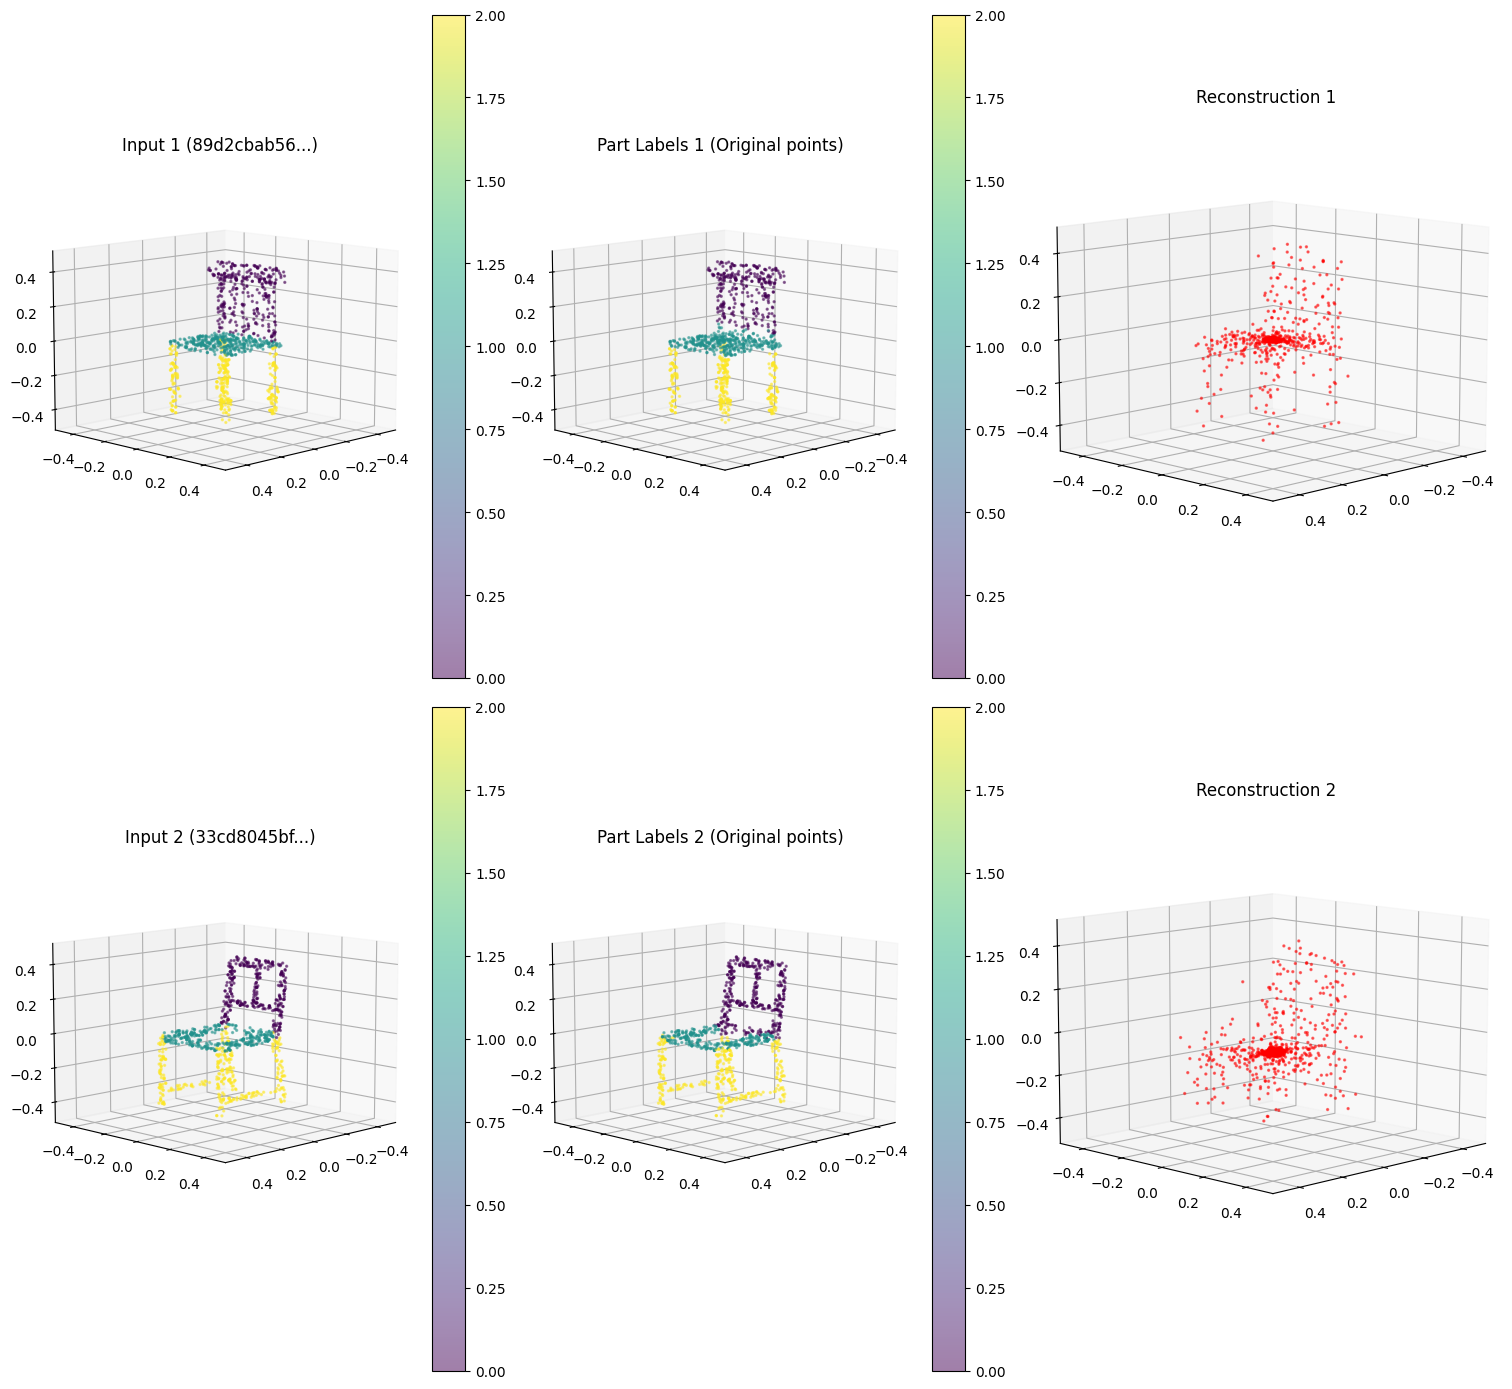

In [10]:
# Plot best and worst reconstructions
# for l in loaders['test']:
#     pc = l['point_cloud']

out = model.reconstruct(loaders['test'], device, return_all_recon_loss=True)
recons, recon_losses = out[0], out[-1]
recon_losses = [r.item() for r in recon_losses]

# best reconstruction
best_idx = np.argmin(recon_losses)
best_model = list(loaders['test'])[best_idx // batch_size]['model_name'][best_idx % batch_size]

# worst reconstruction
worst_idx = np.argmax(recon_losses)
worst_model = list(loaders['test'])[worst_idx // batch_size]['model_name'][worst_idx % batch_size]

plot_examples([best_model, worst_model])

In [11]:
# Last, save the latent codes of the test data and go to the 
# measuring_part_awareness and tsne_plot_with_latent_codes code.

model.eval()
latent_codes = []
test_names = []
for load in loaders['test']:
    pointclouds = load['point_cloud']
    test_names += load['model_name']
    latent_codes += [l.cpu().numpy() for l in model.embed(pointclouds.to(device))]
    
latent_codes = np.array(latent_codes)

# Students TODO: Extract the latent codes and save them, so you can analyze them later.
np.savez(osp.join(top_out_dir, model_tag +'_latent_codes'), 
         latent_codes=latent_codes, 
         test_names=test_names)

In [12]:
model_tag

'experiment_drop0.15_bnorm_kl1e-05_noisy0.001_cdec0.7_alpha1e-05_kdec1_'

### SCRATCH

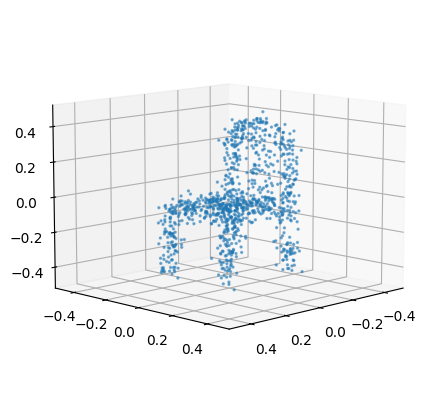

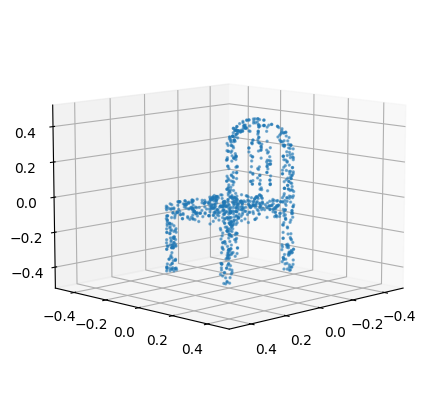

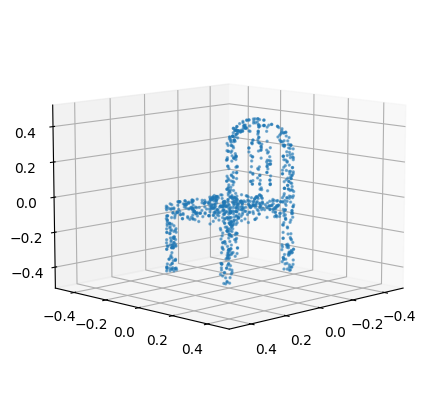

In [33]:
for l in loaders['test']:
    if '4e8d8792a3a6390b36b0f2a1430e993a' in l['model_name']:
        for j in range(len(l['model_name'])):
            if l['model_name'][j] == '4e8d8792a3a6390b36b0f2a1430e993a':
                pc = l['point_cloud'][j]
                tl = l['part_mask'][j]
                
plot_3d_point_cloud(pc + 2e-2 * np.random.randn(*pc.shape), show=True, alpha=0.5, show_axis=True)
plot_3d_point_cloud(pc, show=True, alpha=0.5, show_axis=True)